In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab03.ipynb")

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.api import OLS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Lab 3: Wrangling Survey Data

This lab uses a real-world dataset from the Rurals Water Project Spring Protection Study, collected by Innovations for Poverty Action in 2008. Professor Van Dusen was working as a Research Manager on the project at the time, and this is some of the follow-up work done after the main study.

Part of this study was included in a Journal Article called [_Being Surveyed Can Change Later Behaviour and Related Parameter Estimates_](https://www.pnas.org/doi/epdf/10.1073/pnas.1000776108), published in the Proceedings of the National Academy of Science (PNAS). A summary of the work related to this notebook is contained in this [unpublished draft](https://berkeley.box.com/s/epj41ofw9bph99dim92dsa69gj17puul). 

In this project, there are two datasets from repeated visits to the same households. One of the datasets is at the household-level, and the other one is at the child-level (where there can be multiple children within a given household). Before embarking on the lab, make sure you understand the overall structure of the [survey](https://berkeley.app.box.com/s/2thnb8dan58o7w44mu9tpk1zy8l4c0no); it will be very helpful.

### Learning Objectives:
- Perform an EDA of the Main Rural Project Spring Protection Study, a real-world developmental economics research project
- Understand a complex survey
- Understand the Hawthorne effect and finds empirical evidence
- Analyzes survey data using Pandas tools we have learned so far

---
## Phase 1: Explorative Data Analysis (EDA)

Let's start off with loading in the dataset. Similar to many academic datasets, our dataset is stored in a Stata .dta file.

**Question 1.1:** Load in the dataset `BWM_child_EVDvars.dta` and read it into a Pandas dataframe. Name it `wg_df`.

Hint: Check out this [Pandas documentation](https://pandas.pydata.org/docs/user_guide/io.html) to see how to read in different types of files. 

In [3]:
wg_df = pd.read_stata("BWM_child_EVDvars.dta")
wg_df.head()


,a1_hh_id,a2_spring_id,bwm_round,quiz_id,child_id,child_observed,order_c,c3_1_child_id,c3_2a_name1,c3_2b_name2,...,assWG8,assWG9,assWG10,assWG11,assWG12,assWG13,assWG14,assWG15,MainBWM,round9
0,11006,11,1,1105,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1,11006,11,2,2135,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2,11006,11,3,3141,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,11006,11,4,4099,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
4,11006,11,5,5107,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN


In [4]:
grader.check("q1_1")

q1_1 results: All test cases passed!

**Question 1.2:** Using the `shape` attribute, find the structure of the `wg_df` dataframe. How many rows and columns are there in the dataframe? Assign the values to the corresponding variables `N_rows` and `N_cols`. 

In [5]:
N_rows = wg_df.shape[0]
N_cols = wg_df.shape[1]
N_rows, N_cols

(7782, 224)

In [6]:
grader.check("q1_2")

q1_2 results: All test cases passed!

**Granularity**: Now, let's focus on the granularity of the dataset. We define this as the level of aggregation in our data. 

- For geospatial data, think of data summarized over city, block, street, building, address, room number etc. as increasing level of granularity. 

- For time series data, granularity could for instance be weekly, daily, hourly averages of a variable. 

Survey data might be a bit trickier to entangle, but we're certain you got this!

<!-- BEGIN QUESTION -->

**Question 1.3:** What is the granularity of our dataset? Think about what each row represents. Choose 3 arbitrary columns you find interesting and explain how they help you understand the dataset's granularity. One of them should identify the *primary key* of this dataset. (Note that the primary key can be a combination of 2 or more columns.)

Hint: You can use [`pandas.Series.value_counts`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and/or [`pandas.Series.unique`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).

The granularity of this dataset is understanding how the quality of the city's water affects the health of the children. Because this study is being conducted in a confined location, we can think abuot geospatial data in a more socioeconomic way to see if those who are in higher income levels have access to cleaner water because they can possibly afford a cleaning system. Each row represents data collected from an individual, which means there can be repeats from the same household. I would choose to study the round9, mainBWM, and one of the asswG# column. These columns represent data on diahrrhea, biweekly monitoring, and the use of the water guard, respectively. All of these columns help address the granularity of the dataset. 

<!-- END QUESTION -->

**Question 1.4** How many unique households and springs are there in this dataset? How many rounds of interviews were held? Assign the values to the corresponding variables. 

*Hint:* `a1_hh_id` is the household ID. `a2_spring_id` is the spring ID. `bwm_round` specifies the round of interview. 

In [7]:
num_households = len(wg_df['a1_hh_id'].value_counts())
num_springs = len(wg_df['a2_spring_id'].unique())
num_interview_rounds = len(wg_df['bwm_round'].unique())

print('Households: ', num_households)
print('Springs: ', num_springs)
print('Interview Rounds: ', num_interview_rounds)

Households:  320
Springs:  72
Interview Rounds:  20


In [8]:
grader.check("q1_4")

q1_4 results: All test cases passed!

---
## Phase 2: Understanding the Survey

Our EDA in Phase 1 helped us understand the general structure of the data. Now, turn to the [survey PDF](https://berkeley.app.box.com/s/2thnb8dan58o7w44mu9tpk1zy8l4c0no). Glance over it and try to put yourself in the shoes of the interviewer and answer the questions below. Throughout this lab, you might find it helpful to refer to [Appendix 1](#appendix_1) which connect the relevant survey sections with columns in our dataset.

<!-- BEGIN QUESTION -->

**Question 2.1:** What are the main parts of the survey? In this question, list out each section denoted by a letter and explain in 1 sentence what you believe to be its significance. We'll start you off with two:

- Section A: Introduction with general respondent and interview round information and consent. 
- Section B: Characteristics of respondent. Filled out once during the survey rounds (if respondent stays the same).

* Section C: Basic information about the Child's name, birthdate, and residency.
* Section D: History of the Child's health conditions.
* Section E: performing a physical exam on the child to collect basic vitals and functioning.
* Section F: Collecting the status code of the child.
* Section G: Survey questions asking about water drinkage.
* Section H: Water sample measurement to test the quality of the water.
* Section I: Recording whether or not and how many packets of ORS were given to the child
* Section J: Checking the quality of the survey and ensuring all procedures were accurately followed.
* Section K: A cross check to see if the survey was filled out properly.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2.2:** After your first glance of the survey, what do you deem to be the most important "datapoints" collected that are relevant to the paper's research hypothesis? You can either refer to specific questions and columns. 

*Hint:* this paper focuses on the prevalence of diarrhea across treatment and control groups.

I believe the most important data points are performing a physical exam on the child in section E, testing the quality of the water in section H, and recording the child's diarrhea symtopms. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2.3:** Outside of the paper's "sphere of research interest", what would be interesting datapoints to analyse further? This is an open-ended question, and we suggest you form a short research question and how you would use the data from the survey.

This study was aimed at understanding the prevalence of diarrhea in different treatment groups with different qualities of water. I think other datapoints that are of worth exploring include the behaviors of drinking water from a treated source (filtered) versus an untreated source. Perhaps it would be interesting to see how behavior is also associated with physical symptoms of water quality. It could be interesting to see how the control and treatment groups differ in their health when told that they are drinking from treated water (even if it is just a placebo). 

<!-- END QUESTION -->

---
## Phase 3: Analyzing Disease Prevalence Across Survey Rounds

As we've learned from our EDA and analyzing the survey itself, we understand that our dataset is the result of a series of survey rounds (20 in total). A series of households were interviewed, asked primarily about the general health condition of children in the household over the past week. If a child was ill on the survey day, it was examined further for the symptoms of diarrhea. We now direct our focus to the result of **section D: The Health History tables** (starting Page 7 in the [survey](https://berkeley.app.box.com/s/2thnb8dan58o7w44mu9tpk1zy8l4c0no)) - one filled out for each child in the household per survey round. During the following questions, we suggest you **keep a close eye on the survey.**

**Question 3.1:** How many households were surveyed each round? Assign the result to a dataframe `grouped_by_round` with only two columns `bwm_round` and `count`. For now, exclude the survey rounds denoted 99 and 161.

In [9]:

mask = wg_df['bwm_round'].isin([99,161])
wg_df[~mask]
relevant_rounds = wg_df[~mask]
grouped_by_round =relevant_rounds.groupby(by = 'bwm_round').count()
grouped_by_round = grouped_by_round.rename(columns={'a1_hh_id': 'count'})
#grouped_by_round = grouped_by_round.iloc[:18, :]
grouped_by_round = grouped_by_round.reset_index()
grouped_by_round =grouped_by_round[['bwm_round','count']]
grouped_by_round 


,bwm_round,count
0,1,377
1,2,373
2,3,375
3,4,382
4,5,418
5,6,402
6,7,415
7,8,393
8,9,380
9,10,408


In [10]:
grader.check("q3_1")

q3_1 results: All test cases passed!

We can plot the data using a bar chart, as done below.

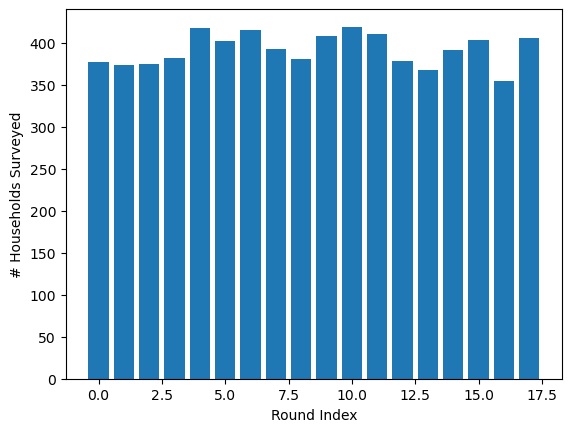

In [11]:
plt.bar(grouped_by_round.index,grouped_by_round['count']);
plt.xlabel("Round Index")
plt.ylabel("# Households Surveyed");

<!-- BEGIN QUESTION -->

**Question 3.2**: Discuss the plot and describe one potential cause for the variation in the number of participating households across rounds. 

This plot shows the number of households in each of the survey rounds. A potential reason as to why there is variation across the number of households across rounds is that some families may have moved which impacted the number of households surveyed in each round.

<!-- END QUESTION -->

#### Rounds 99 and 161

During the survey, a decision was made to survey an additional set of households that were not being surveyed as frequently. Round 99 happened at the same time as round 9 as a new control group of households, and round 161 happened at the same time as round 16.

In other words, the researchers added a control group that was "less frequently surveyed". These households reported much higher diarrhea prevalence. We later use these extra-rounds to quantify the [Hawthorne effect](https://en.wikipedia.org/wiki/Hawthorne_effect) discussed in lecture.

**Question 3.3**: We now turn our attention to the variable of interest: The 7-day recall variable for diarrhea in the past week, denoted `d6a1_7dd_n` in the dataset. It is a binary categorical variable: 1 if a surveyed child in a given household had diarrhea the past 7 days, 0 if not. In the code cell below, generate a Series with the number of households that did/didn't have children with diarrhea in the past 7 days.


In [12]:
diarrhea_groups = [
   wg_df[(wg_df['d6a1_7dd_n'] == 0) & (wg_df['bwm_round'] != 99) & (wg_df['bwm_round'] != 161)]['a1_hh_id'].value_counts().sum(),
    wg_df[(wg_df['d6a1_7dd_n'] == 1) & (wg_df['bwm_round'] != 99) & (wg_df['bwm_round'] != 161)]['a1_hh_id'].value_counts().sum()]
diarrhea_groups =pd.Series(diarrhea_groups)
diarrhea_groups

0    6525
1     526
dtype: int64

In [13]:
grader.check("q3_3")

q3_3 results: All test cases passed!

We plot the data using a bar chart once again.

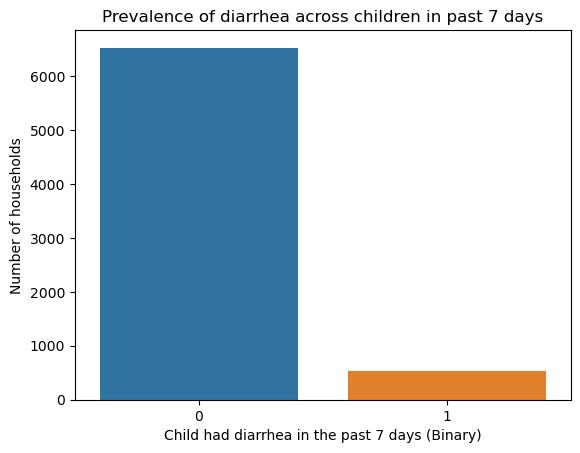

In [14]:
ax = sns.barplot(x=diarrhea_groups.index, y=diarrhea_groups.values);
ax.set(xlabel='Child had diarrhea in the past 7 days (Binary)', ylabel='Number of households', 
       title='Prevalence of diarrhea across children in past 7 days');

**Question 3.4**: How does our variable of interest,`d6a1_7dd_n`, change across survey rounds? In the code cell below, make a data frame that has the number of reported cases of diarrhea and number of cases of no diarrhea across each round. The first few rows of the output have been given below to serve as an example, please DO NOT hard code in your dataframe.

In [15]:
data = {
    'bwm_round': [1, 1, 2, 2, 3, 3],
    'd6a1_7dd_n': [0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
    'count': [292, 85, 332, 41, 329, 46]
}
samp_df = pd.DataFrame(data)
samp_df

,bwm_round,d6a1_7dd_n,count
0,1,0.0,292
1,1,1.0,85
2,2,0.0,332
3,2,1.0,41
4,3,0.0,329
5,3,1.0,46


In [16]:
wg_df1 = wg_df.groupby(by = ['bwm_round', 'd6a1_7dd_n']).count()
wg_df2 = wg_df1.reset_index()
wg_df2 = wg_df2[['bwm_round','d6a1_7dd_n',	'a1_hh_id']]
wg_df2 = wg_df2.rename( columns = {'a1_hh_id' : 'count'})
wg_df2

,bwm_round,d6a1_7dd_n,count
0,1,0.0,292
1,1,1.0,85
2,2,0.0,332
3,2,1.0,41
4,3,0.0,329
5,3,1.0,46
6,4,0.0,360
7,4,1.0,22
8,5,0.0,370
9,5,1.0,48


In [17]:
wg_plot_df = wg_df2

In [18]:
grader.check("q3_4")

q3_4 results: All test cases passed!

Now, as we're visualizing change over time, we plot the data using a line plot.

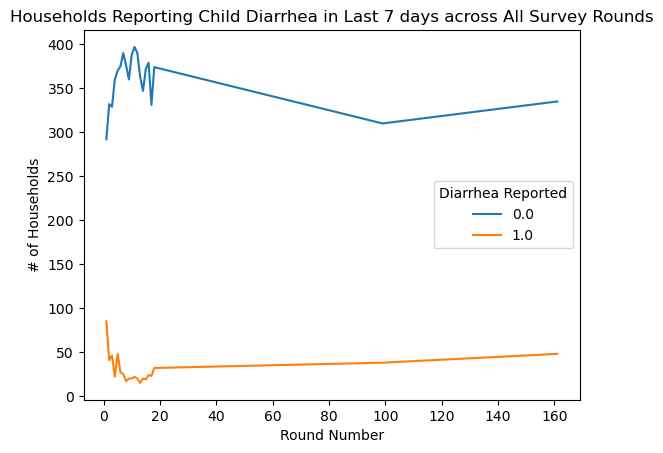

In [19]:
ax = sns.lineplot(data=wg_plot_df,x='bwm_round', y='count', hue='d6a1_7dd_n');
plt.legend(title='Diarrhea Reported')
ax.set(xlabel='Round Number', ylabel='# of Households', 
       title='Households Reporting Child Diarrhea in Last 7 days across All Survey Rounds');

<!-- BEGIN QUESTION -->

**Question 3.5**: Do you observe any particular trends in the reported past 7-day prevalence of child diarrhea across the survey rounds? Think of how its prevalence changes relative to previous survey rounds. Furthermore, discuss potential reasons for the trends you are observing.

I noticed that in the past 7-day prevalence, there is a distinction between the treatment and control groups. In both of the groups, the overal range of the diarrhea reports is about the same across from the first round to the last round. In the group that reported diarrhea, there is a small and steady increase in the number of diarrhea reported from round 20 to 160. There is more variation for both groups in rounds 0-20. From around survey round 100 to 160, the people that didn't report diarrhea increased. Potential reasons could be weather related changes or changes in food quality. 

<!-- END QUESTION -->

**Question 3.6**: Let's dive deeper into the trends we're observing here. Obtain the *proportion* of households reporting child diarrhea across the survey rounds and store it in `wg_plot_df_mean`. The resulting dataframe should have the `bwm_round` as the index and only 1 column `proportion`, representing the proportion of households reporting child diarrhea in that survey round.


In [20]:
wg_df3 = wg_df2.groupby(by = "bwm_round", group_keys=False)[['d6a1_7dd_n','count']].apply(lambda x:x)
wg_df3 = wg_df3[['d6a1_7dd_n','count']]
wg_df3 = wg_df3[wg_df3['d6a1_7dd_n'] == 1]
wg_df3 = wg_df3['count']
relevant_rounds1 = relevant_rounds.reset_index()

wg_df4 = wg_df3.reset_index()
proportion = wg_df4['count']/relevant_rounds1['a1_hh_id']
wg_plot_df_mean = pd.DataFrame ({'bwm_round' : relevant_rounds1['bwm_round'] , 'proportion' :proportion})
wg_plot_df_mean = wg_plot_df_mean.set_index('bwm_round')
wg_plot_df_mean = wg_plot_df_mean.head(18)
wg_plot_df_mean

,proportion
bwm_round,
1,0.007723
2,0.003725
3,0.004180
4,0.001999
5,0.004361
6,0.002453
7,0.002271
8,0.001545
8,0.001817


In [21]:
wg_plot_df_mean = relevant_rounds.groupby(by=['bwm_round','d6a1_7dd_n']).count()
wg_plot_df_mean = wg_plot_df_mean.reset_index()
proportion = wg_plot_df_mean.groupby( by = 'bwm_round').apply(lambda x: x['a1_hh_id'] / x['a1_hh_id'].sum()).reset_index(drop=True)
wg_plot_df_mean['proportion'] = proportion
wg_plot_df_mean = wg_plot_df_mean[['bwm_round','proportion']]
wg_plot_df_mean= wg_plot_df_mean.iloc[1::2]
wg_plot_df_mean= wg_plot_df_mean.set_index('bwm_round')
wg_plot_df_mean

,proportion
bwm_round,
1,0.225464
2,0.109920
3,0.122667
4,0.057592
5,0.114833
6,0.067164
7,0.060241
8,0.043257
9,0.052632


In [22]:
grader.check("q3_6")

q3_6 results: All test cases passed!

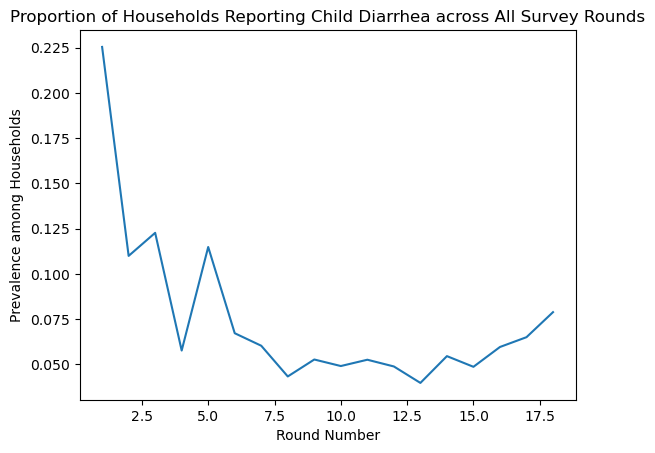

In [23]:
ax = sns.lineplot(x=wg_plot_df_mean.index, y=wg_plot_df_mean['proportion']);
ax.set(xlabel='Round Number', ylabel='Prevalence among Households', 
       title='Proportion of Households Reporting Child Diarrhea across All Survey Rounds');

<!-- BEGIN QUESTION -->

**Question 3.7**: In the code cell below, generalize the prevalence plot code in the form of a function that takes in a dataframe, a condition column (e.g `d6a1_7dd_n`) and a name (e.g. Diarrhea), and outputs a plot like above. You can assume that the round numbers will always be in a column named `bwm_round`. You can skip labelling the x and y axes for this question only.


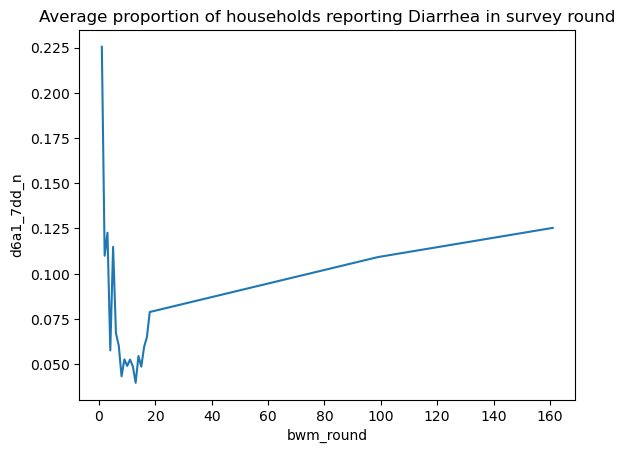

In [24]:
"""
Takes in the condition column and actual name. Outputs plots of average prevalence of 
condition across survey rounds. 
"""
def prevalence_plotter(df, condition_column, condition_name):

    plot_df_mean = df.groupby(by=['bwm_round',condition_column]).count()
    plot_df_mean = plot_df_mean.reset_index()
    proportion = plot_df_mean.groupby( by = 'bwm_round').apply(lambda x: x['a1_hh_id'] / x['a1_hh_id'].sum()).reset_index(drop=True)
    plot_df_mean[condition_column] = proportion
    plot_df_mean = plot_df_mean[['bwm_round',condition_column]]
    plot_df_mean= plot_df_mean.iloc[1::2]
    plot_df_mean= plot_df_mean.set_index('bwm_round')
    
    title_string = f"Average proportion of households reporting {condition_name} in survey round"
    ax = sns.lineplot(x=plot_df_mean.index, y=plot_df_mean[condition_column]);
    ax.set(title=title_string);
    #return px.line(df_plot_prep, x='bwm_round', y=condition_column, title=title_string)

prevalence_plotter(wg_df, 'd6a1_7dd_n', 'Diarrhea')


<!-- END QUESTION -->

Now, we will apply the function on a dictionary of diseases already prepared for you. This will generate four plots that describe the average proportion of households reporting a certain disease over the survey rounds.

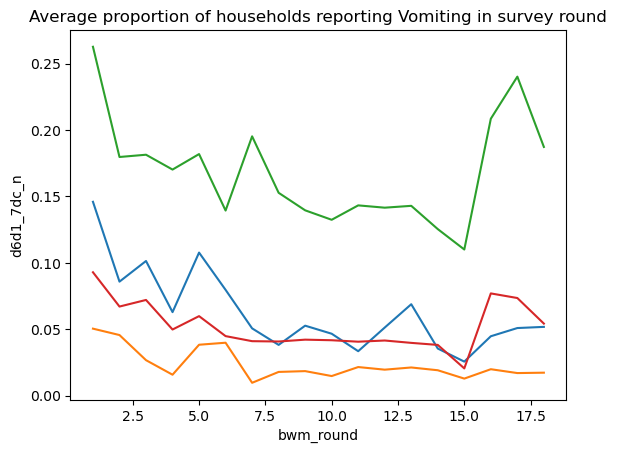

In [25]:
conditions = {
'd6d1_7dc_n' : 'Cough',
'd7d2_7dcn_n' : 'Chest Noise',
'd6b_7day_fever_n' : 'Fever',
'd6c_7day_vomiting_n':'Vomiting'}

for condition_column, condition_name in conditions.items():
    prevalence_plotter(relevant_rounds, condition_column, condition_name)


<!-- BEGIN QUESTION -->

**Question 3.8**: Choose one of the plots above and thoroughly reflect on a set of observations in a few sentences. Can you think of why disease prevalence is steadily declining as the number of survey rounds increase? And, what could have caused the sudden uptick in the last rounds? (Hint: Revisit the lecture slides).

In the first plot, disease prevalence is steadily declining as the number of survey rounds increase because this could be due to the law of large numbers. As we reach more survey rounds with this population, the amount of disease prevalence may start to decine because this might be the base number of diseases in this population. The sudden spike in the last rounds could be due to the seasonality of diarrhea. 

<!-- END QUESTION -->

---
## Phase 4: Analyzing the Hawthorne Effect

In this phase of the project we seek to analyze and quantify the [Hawthorne effect](https://en.wikipedia.org/wiki/Hawthorne_effect) mentioned in lecture. In general terms, it is a positive change in the performance of a group of persons taking part in an experiment or study due to their perception of being singled out for special consideration (Collins Dictionary). In our context, we define it as the decrease in disease prevalence attributed to the mere fact that households are *aware of themselves being surveyed.* Let's see if we can put a number to it!

**Question 4.1**: Obtain the proportion of households with reported diarrhea from rounds "99" and "161", similar to the output of question 3.6. Store the results in the dataframe `special_proportions`.

In [26]:
special_proportions = wg_df.groupby(by=['bwm_round','d6a1_7dd_n']).count()
special_proportions = special_proportions.reset_index()
proportion = special_proportions.groupby( by = 'bwm_round').apply(lambda x: x['a1_hh_id'] / x['a1_hh_id'].sum()).reset_index(drop=True)
special_proportions['d6a1_7dd_n'] = proportion
special_proportions = special_proportions[['bwm_round','d6a1_7dd_n']]
special_proportions= special_proportions.iloc[1::2]
special_proportions = special_proportions.tail(2)
special_proportions = special_proportions.rename( columns = {'d6a1_7dd_n' : 'proportion'})
special_proportions= special_proportions.set_index('bwm_round')
special_proportions

,proportion
bwm_round,
99,0.109195
161,0.125326


In [27]:
grader.check("q4_1")

q4_1 results: All test cases passed!

Let's plot the results you got on the line plot from question 3.7.

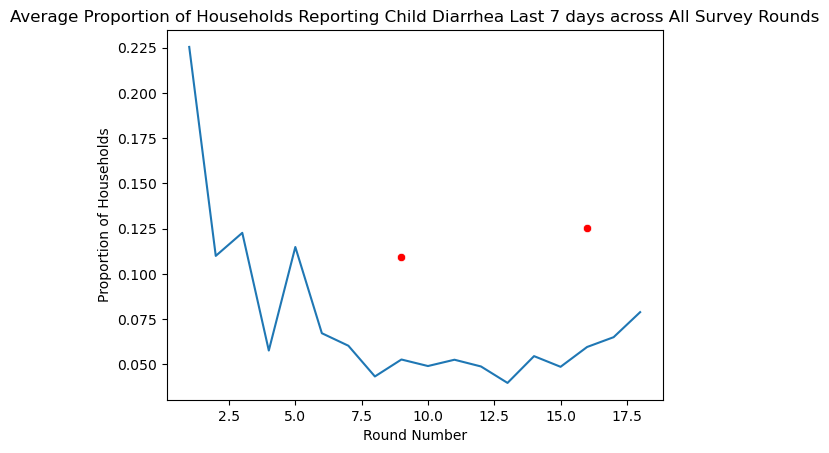

In [28]:
special_proportions_plot = special_proportions.copy()
special_proportions_plot["bwm_round"] = np.array([9, 16])

fig, ax = plt.subplots()
sns.lineplot(x=wg_plot_df_mean.index, y=wg_plot_df_mean['proportion'], ax=ax)
sns.scatterplot(data=special_proportions_plot, x='bwm_round', y='proportion', ax=ax,color='red');
ax.set(title='Average Proportion of Households Reporting Child Diarrhea Last 7 days across All Survey Rounds',
      xlabel='Round Number', ylabel='Proportion of Households');

#wg_plot_df_mean

<!-- BEGIN QUESTION -->

**Question 4.2**: Look at the graph above. The red points are the corresponding control groups 99 and 161. How different are these from the normal group quantitatively? (Feel free to just eyeball it or write some code) Are you surprised by your findings? 

Just by estimating, I would say that the control groups are about 2.5 times higher in the proportion of households that report diarrhea. Both groups seem to be outliers. This difference makes it seem that the treatment worked because the controls are like outliers. 

<!-- END QUESTION -->

---
## Phase 5: Analyzing WaterGuard Usage

Now, let's turn our attention to the effect of [WaterGuard](https://www.engineeringforchange.org/solutions/product/waterguard/) usage on disease prevalence across households.

**Question 5.1**: Read in the `BWM_HH_EVDvars.dta` dataset and convert it into a dataframe. 

In [29]:
hh_wg = pd.read_stata('BWM_HH_EVDvars.dta')
hh_wg


,quiz_id,bwm_round,a1_hh_id,a2_spring_id,interview_date,a5_date_interview_day,a5_date_interview_month,a5_date_interview_year,a8_data_entry_id,a9_data_entry_comments,...,child_observed20,child_observed21,child_observed22,spring_id,wave,_merge,h5clcolor,g5WG,G5XH5,date_round
0,1001,1,872002,872,2007-05-09,9,5,2007,NaN,,...,0,0,0,872,2.0,3,1.0,1.0,1.0,2007-05-09
1,1002,1,859009,859,2007-05-09,9,5,2007,NaN,,...,0,0,0,859,1.0,3,1.0,1.0,1.0,2007-05-09
2,1003,1,872007,872,2007-05-09,9,5,2007,NaN,,...,0,0,0,872,2.0,3,0.0,0.0,0.0,2007-05-09
3,1004,1,764029,764,2007-05-09,9,5,2007,NaN,,...,0,0,0,764,3.0,3,0.0,0.0,0.0,2007-05-09
4,1005,1,764016,764,2007-05-09,9,5,2007,NaN,,...,0,0,0,764,3.0,3,0.0,0.0,0.0,2007-05-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3090,99145,99,884013,884,2007-08-31,31,8,2007,NaN,.,...,0,0,0,884,2.0,3,0.0,0.0,0.0,2007-08-31
3091,99146,99,886010,886,2007-08-31,31,8,2007,NaN,.,...,0,0,0,886,2.0,3,0.0,0.0,0.0,2007-08-31
3092,99147,99,784006,784,2007-08-31,31,8,2007,NaN,.,...,0,0,0,784,3.0,3,1.0,1.0,1.0,2007-08-31
3093,99148,99,784004,784,2007-08-31,31,8,2007,NaN,.,...,0,0,0,784,3.0,3,1.0,1.0,1.0,2007-08-31


In [30]:
grader.check("q5_1")

q5_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 5.2**: What does each row of `hh_wg` contain? What does it say about the granularity (or the level of aggregation)? How does it compare to the dataframe used in phase 1-4?

Each row of hh_wg represents a unique house in a different survey round and spring. However, this dataframe doesn't include the children. This means that the data is less granular because there is less specificity in the data. 

<!-- END QUESTION -->

**Question 5.3:** How many households appear in each survey round? 

Hint: The resulting dataframe should have two columns `bwm_round` and `a1_hh_id`. 

In [31]:
hh_round = hh_wg.groupby (by = 'bwm_round').count()
hh_round = hh_round[["a1_hh_id"]]
hh_round

,a1_hh_id
bwm_round,
1,156
2,153
3,151
4,153
5,162
6,156
7,163
8,154
9,154


In [32]:
grader.check("q5_3")

q5_3 results: All test cases passed!

**Question 5.4:** In each round, how many households have validated usage of WaterGuard? 

Hint: The column with the obscure name of `G5XH5` might be of interest to you - it's a dummy variable for validated WG usage! 
The resulting dataframe should have three columns: `bwm_round`, `Validated WaterGuard Usage` and `Count`.

In [33]:
hh_round_vld = hh_wg.groupby(['bwm_round','G5XH5'])[['a1_hh_id']].count().reset_index()

hh_round_vld.rename(columns = {'G5XH5': 'Validated WaterGuard Usage'}, inplace=True)
hh_round_vld.rename(columns = {'a1_hh_id': 'Count'}, inplace=True)
hh_round_vld

,bwm_round,Validated WaterGuard Usage,Count
0,1,0.0,126
1,1,1.0,30
2,2,0.0,123
3,2,1.0,30
4,3,0.0,107
5,3,1.0,44
6,4,0.0,110
7,4,1.0,43
8,5,0.0,119
9,5,1.0,43


In [34]:
grader.check("q5_4")

q5_4 results: All test cases passed!

Now we turn to a truly interesting part of the survey: How does the promotion of WaterGuard affect the actual use of the product? You might have noticed the `assign_wg` column in both of our datasets: This denotes whether or not a given household has been promoted WG as a product. Promotion includes free samples, encouragement scripts, and follow-ups on water quality. The encoding is as follows: 

- `assign_wg` = 0 is a control household with no WG Promotion.
- `assign_wg` = 1 is a household with WG Promotion.

Here's an example of how a household with WG promotion looks like across all survey rounds:  

In [35]:
hh_wg[hh_wg['a1_hh_id']== 872002][['bwm_round', 'assign_wg']]

,bwm_round,assign_wg
0,1,1.0
219,2,1.0
376,3,1.0
518,4,1.0
674,5,1.0
834,6,1.0
969,7,1.0
1159,8,1.0
1271,9,1.0
1483,10,1.0


**Question 5.5:** Select the `bwm_round`, `G5XH5`, `assign_wg` columns from our `hh_wg` dataset. Then rename `G5XH5` as `validated_wg` and `assign_wg` as `promoted_wg`, respectively. Only include the normal survey rounds (i.e. not including rounds 99 and 161). Assign your results to `df_55`.

In [36]:
df_55 = hh_wg[(hh_wg['bwm_round'] != 99) & (hh_wg['bwm_round'] != 161)][['bwm_round','G5XH5','assign_wg']]

df_55 = df_55.rename(columns={'G5XH5': 'validated_wg', 'assign_wg': 'promoted_wg'})
df_55

,bwm_round,validated_wg,promoted_wg
0,1,1.0,1.0
1,1,1.0,1.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,1.0
...,...,...,...
2948,18,0.0,1.0
2949,18,0.0,0.0
2950,18,0.0,1.0
2951,18,0.0,1.0


In [37]:
grader.check("q5_5")

q5_5 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 5.6:** Which of the two Wateguard columns inform us whether or not a given household is in the *treatment* or *control* group? Which column stores our *outcome* variable?

In the two Watergaurd columns, promoted_wg gives the treatment or control group. validated_wg stores the outcome variable. 

<!-- END QUESTION -->

**Question 5.7:** How does validated Waterguard usage vary in our treatment and control groups across all survey rounds? Use `df_55` to find out the average proportion of households with validated WG usage per round for the treatment and control group respectively. Your resulting dataframe should have 3 columns: `bwm_round` (round number), `promoted_wg` (binary column indicating treatment or control group), and `proportion` (proportion of households using waterguard for the treatment/control group in that round). Assign your results to `df_57`.

In [38]:
total = df_55
total = total.groupby(by=['bwm_round', 'promoted_wg'])['validated_wg'].count()
total = pd.DataFrame(total)

df_57 = df_55[df_55['validated_wg']==1]
df_57 = df_57.groupby(by =['bwm_round', 'promoted_wg'])['validated_wg'].count()
df_57 = pd.DataFrame(df_57)

df_57= df_57.reset_index()
total = total.reset_index()

proportion = df_57['validated_wg']/total['validated_wg']

df_57['validated_wg'] = proportion
df_57 = df_57.rename(columns = {'validated_wg' :'proportion'})
df_57

,bwm_round,promoted_wg,proportion
0,1,0.0,0.060976
1,1,1.0,0.337838
2,2,0.0,0.064103
3,2,1.0,0.333333
4,3,0.0,0.080000
5,3,1.0,0.500000
6,4,0.0,0.089744
7,4,1.0,0.480000
8,5,0.0,0.095238
9,5,1.0,0.448718


In [39]:
grader.check("q5_7")

q5_7 results: All test cases passed!

We plot the data below.

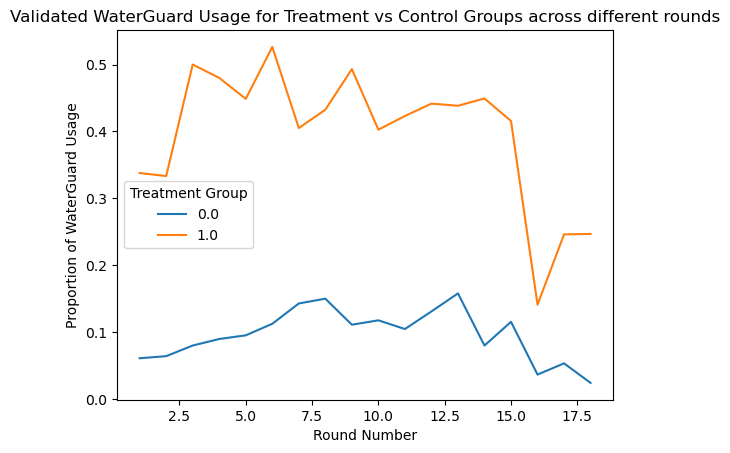

In [40]:
ax = sns.lineplot(data=df_57,x='bwm_round', y='proportion', hue='promoted_wg');
plt.legend(title='Treatment Group')
ax.set(xlabel='Round Number', ylabel='Proportion of WaterGuard Usage', 
       title='Validated WaterGuard Usage for Treatment vs Control Groups across different rounds');

**Question 5.8:** Does the plot above surprise you? Did you expect the effect of WG promotion to be larger, smaller, or follow another trend curve than what we witness above? (2-3 sentences should suffice.)

The plot above does surprise me a bit because the control group also had some level of WaterGuard Usage. I honestly think that the effect of WG is expected because I think people would start strong in using the waterguard and then decrease as the number of rounds increase.

**Question 5.9 (Extra Credit):** Now, quantify the relationship between our dependent variable (`validated_wg`) and our independent variable (`promoted_wg`). Proceed with this performing a Ordinary Least Squares Regression using the [`statsmodel`](https://www.statsmodels.org/stable/index.html) package. You should return a regression summary. 

In [41]:
df_reg = df_55.dropna()

y = df_reg['validated_wg']
X = df_reg['promoted_wg']

# Remember to add an intercept term to X
X = sm.add_constant(X)

# Fit model and return the summary
model = sm.OLS(y,X)
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           validated_wg   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     396.4
Date:                Sat, 10 Feb 2024   Prob (F-statistic):           1.34e-82
Time:                        02:18:48   Log-Likelihood:                -1411.8
No. Observations:                2797   AIC:                             2828.
Df Residuals:                    2795   BIC:                             2839.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0961      0.011      9.116      0.000       0.075       0.117
promoted_wg     0.3021      0.015     19.911      0.000       0.272       0.332
==============================================================================
Omnibus:                      338.299   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              426.456
Skew:                           0.929   Prob(JB):                     2.49e-93
Kurtosis:                       2.547   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
grader.check("q5_9")

q5_9 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 5.10 (Bonus):** Interpret your findings using the [Sign, Significance, and Size framework](https://are.berkeley.edu/courses/EEP118/spring2014/section/Handout4_2014.pdf). 

Hint: If you're new to interpreting `statsmodels` summaries, you might find this [blog post](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a) helpul.

Sign = positive, there should be a positive relation with the promoted of waterguard usage and the validation of it. 
Significance = the standard error and the t value make the promoted_wg statistically significant. 
Size = by promoting the waterguard usage, the validation of the watergaurd usage increases by about 0.3021.

<!-- END QUESTION -->

---
## Phase 6: Impact of More-Frequent Surveying (Optional)

In this last part, we focus our attention to the main concern of Banerjee et al. (2010) _[Being Surveyed Can Change Later Behaviour and Related Parameter Estimates](https://www.pnas.org/doi/10.1073/pnas.1000776108)_. They ask:

- Does completing a household survey change the later behaviour of those surveyed?

We direct our focus to what our data may tell us: 

- What's the impact on of more-frequent surveys on chlorine use and diarrhea prevalence?

More specifically, we'd like to replicate the first columns of the following regression table, but without the protected spring variable and its interaction variable with 'surveyed more frequently'. Are you up for the challenge?

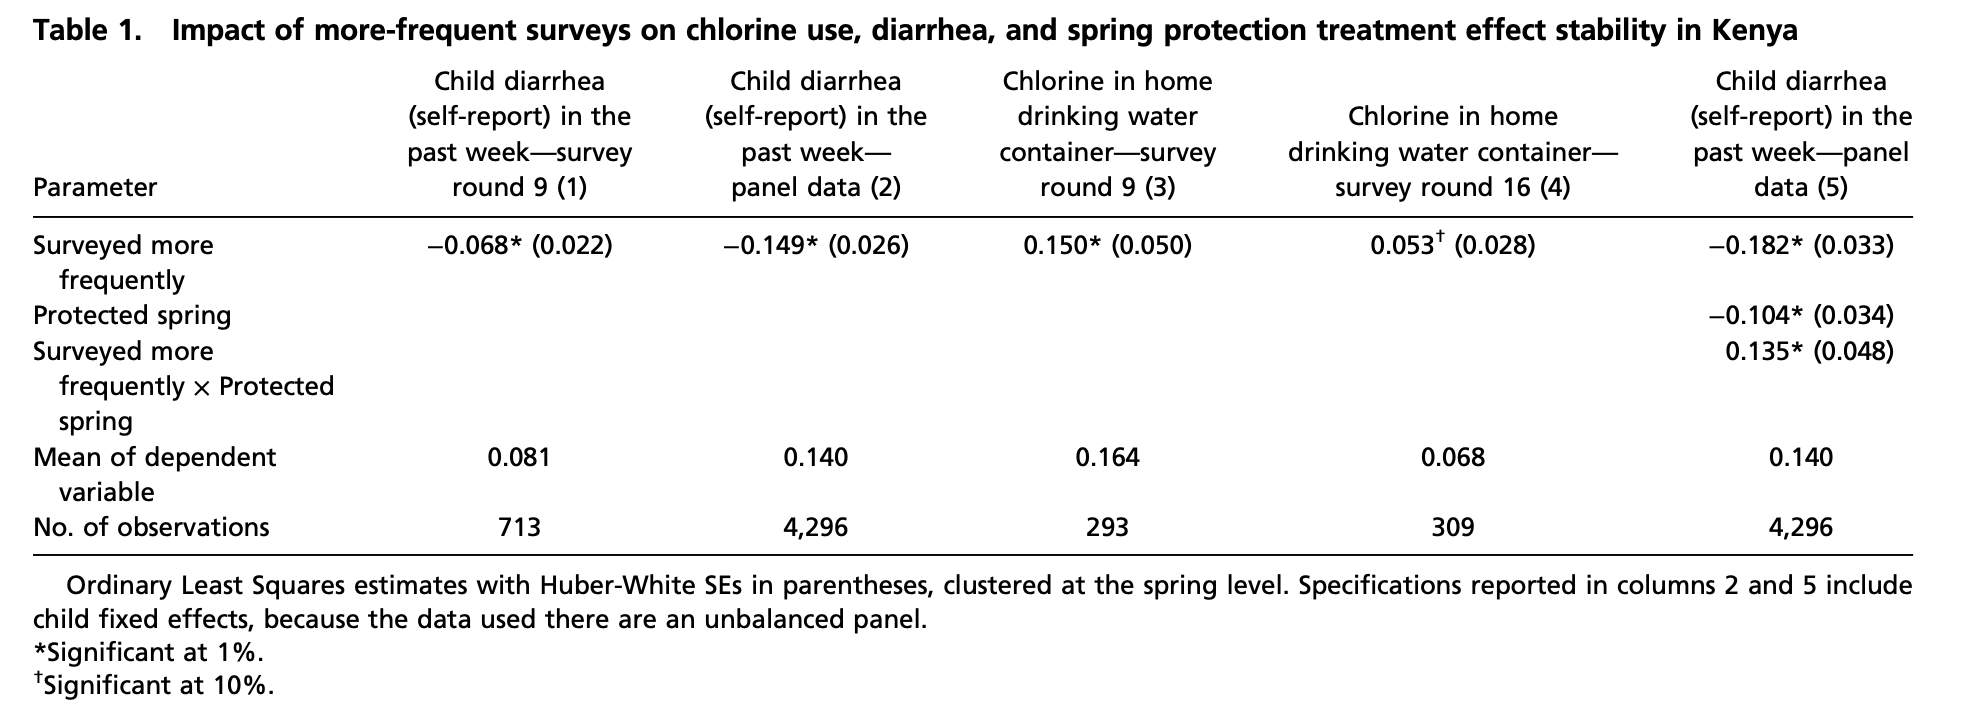

Before you start with the regressions, make sure you understand the experimental design as described in the [paper](https://www.pnas.org/doi/epdf/10.1073/pnas.1000776108)'s results section:

> The sample for this experiment is composed of 330 households in rural western Kenya who were randomly selected froma frame of 1,500 households involved in a larger randomized evaluation of spring protection and WaterGuard use (23). Of these, 170 households were randomly assigned to be surveyedabout health status biweekly [to accord with common practice insurveys of child diarrhea in epidemiology (9, 10)] for 18 2-wk rounds beginning in May 2007, although there was a 4-mo gap between rounds 15 and 16 owing to the postelection violence in early 2008. Afinal survey (round 19) was conducted 7 mo later in December 2008. The remaining 160 households were randomly selected to get the same survey just three times, or every 6 mo, during the same period: in biweekly survey rounds 9 (September 2007), 16 (April 2008), and 19 (December 2008). More than 97% of both the biweekly and low-frequency groups completed at least one of their survey rounds; 90% of the biweekly group completed at least 17 of the 19 surveys, and 90% of the low-frequency group completed at least 2 of the 3 surveys. ...

### Merging WG with Diarrhea Prevalence Data

Answering this, we first need to merge our WaterGuard usage data onto our diarrhea prevalence data.

We start off by selecting all rounds (including 9 and 16) and rename the columns as done earlier. This time, we also sort for survey rounds and households, to make the data a bit more interpretable.

In [ ]:
# Select relevant rounds and rename.
df = hh_wg.rename({'G5XH5':'validated_wg', 'assign_wg': 'promoted_wg'}, axis=1)

# Sort for household id and round number.
df_s = df.sort_values(['a1_hh_id','bwm_round'])
df_s.head()

Next, our goals is to understand how the 7-day recall rate for diarrhea changes across household in each round. To do so, we need to find the data corresponding to the following answer in the survey:

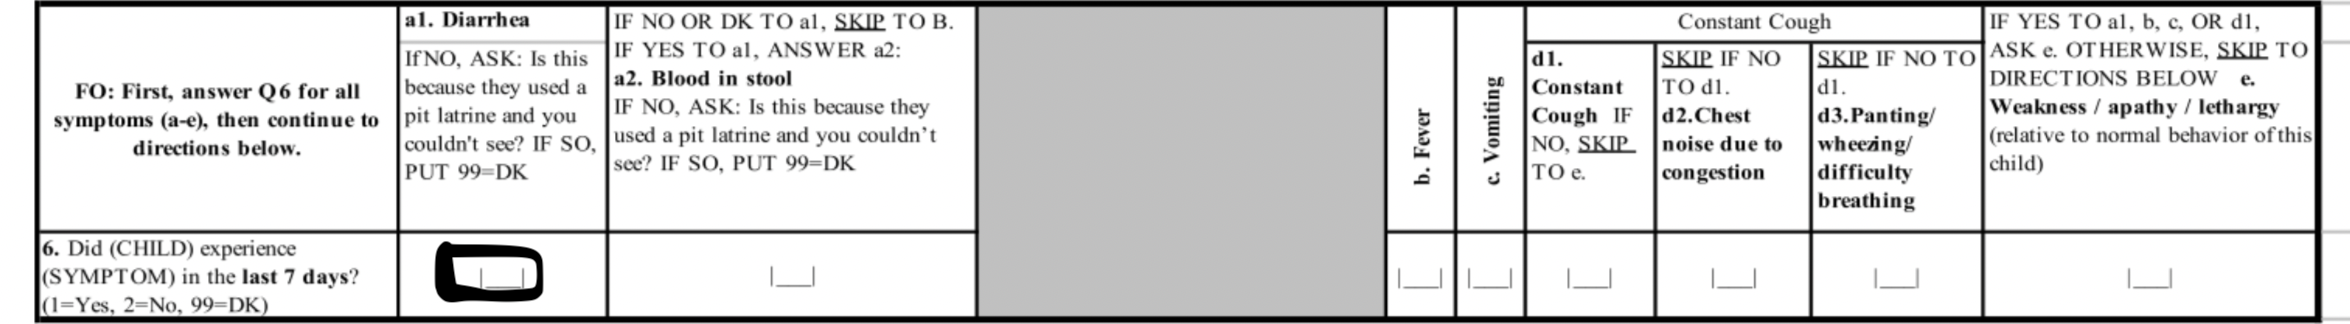

The relevant columns are all named `d6a1_7day_diarrhea_XX` with a number from 01 to 22 corresponding to child 'number' for each household. For example, if `d6a1_7day_diarrhea_04` is 1.0, child number 4 of that household in that given round had diarrhea the past 7 days.

Now that we have identified our columns of interest and their format, we need to sub-select the relevant columns for further investigation.

**Question 6.2:** In the following cell, create `df_disease` that contains only the relevant columns for each given household using `df_s`. 

Hint: The relevant columns are all named `d6a1_7day_diarrhea_XX` with a number from 01 to 22 corresponding to child 'number' for each household.

In [ ]:
# Subselect all relevant disease columns - per household per round
# df_disease = ...
# df_disease.head()

To clarify, `df_disease`'s rows now represent a household in a given round, and each column informs us whether or not a given child (up to 22!) has had diarrhea the past 7 days. But, there's something interesting with the values present: What does '2' or '99' that we observe when running `.describe()` represent?

In [ ]:
# df_disease.describe()

If we take a second look at the specific survey entry below, we observe that the 99 is an encoding for 'DK', shorthand for 'Don't know.' In this survey data, '2.0' is an encoding for 'no'. Let's deal with these encodings to avoid faults in our analysis!

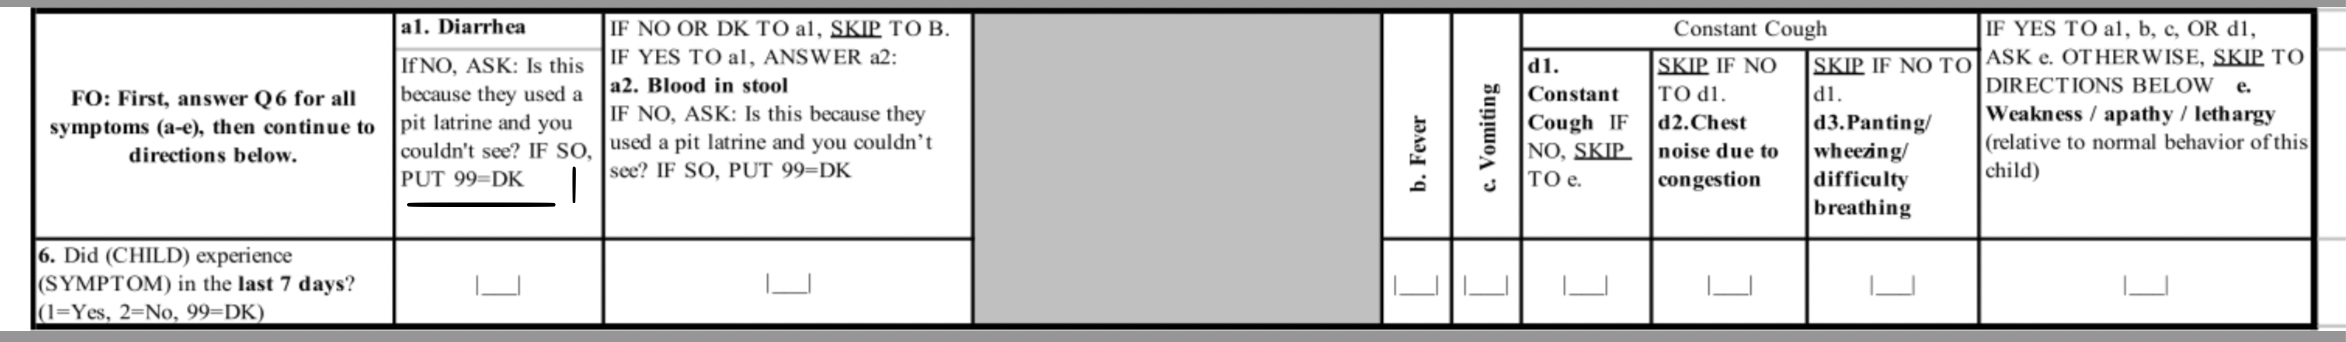

**Question 6.3:** In the following cell, use the [`pandas.DataFrame.replace`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) function to change both 2.0 and 99.0 entries to 0.

In [ ]:
# YOUR CODE HERE
# As 2.0 is that encoded answer for a no, we replace each such value with 0.
# df_disease = ...
# We do the same for values of 99, as that is the encoding for 'Don't know.'
# df_disease = ...
# df_disease.head()

Being interested in the diarrhea prevalence of each household in a given survey round, we ought to summarise our 22 columns into a meaningful variable.

**Question 6.4:** In the next question, you'll be asked to aggregate the findings above *horizontally*, that is, across columns. Before you do so, consider to options: taking the average or summing them together. What would the benefits and/or trade-offs of each approach be?

*Your answer here.*

**Question 6.5:** In the following cell, perform a horizontal aggregation of the columns with the chosen method from 6.4.

Hint: remember that we can specify the `axis` parameter in both `.mean()` and `.sum()`!

In [ ]:
# YOUR CODE HERE
# df_d_agg = ...
# df_d_agg.head()

**Question 6.6:** Now, merge your aggreagated column back onto the existing `df_s`. Your final `df_m`should contain the relevant columns `'bwm_round'`, `'a1_hh_id'`, and `'validated_wg'`, plus the aggregate. Rename this one `child_diarrhea`.

In [ ]:
# YOUR CODE HERE
# Merge disease prevalence per household per round back to originial df.
# df_m = ...

# Relabel columns
# df_m.columns = ...

# df_m.head()

### Regressing Child Diarrhea Prevalence on validated WG usage

**Question 6.7:** With that done, create `val_prep`, `df_m` grouped by `bwm_round` and whether or not the household had validated WG usage. It should contain the mean 7-day diarrhea household prevalence for each round and treatment/control group. After that, perform the regression as specified below.

In [ ]:
# YOUR CODE HERE
# val_prep = ...
# val_prep.head()

The cell below plots our two trend lines: 7-day Mean Diarrhea Prevalence in households with and without validated WG usage. To illustrate the trend lines, we drop our less surveyed households, denoted as round 99 and 161.

In [ ]:
# px.line(val_prep[val_prep['bwm_round'] <19], x='bwm_round', y='child_diarrhea', color = 'validated_wg',
#         title='7-day Mean Diarrhea Prevalence in Households with and without Validated WG Usage Across Rounds')

**Question 6.8:** In the plot above, it appears that the 7-day Mean Diarrhea Prevalence in households are lower for validated WG - on average. In the cell below, quantify the relationship between `d_7_days_mean_prev` and `validated_wg` and interpret your findings, following the example from exercise 5.10. Some questions to consider: What are you observing? Did you expect a larger impact from validated WaterGuard usage? Is this relationship significant?

In [ ]:
# YOUR CODE HERE (REGRESSION)

*Your answer here. (SSS-interpretation).*

### Regressing Child Diarrhea Prevalence on Survey Rounds 

Next, let's turn our attention back towards the main focus of the aforementioned paper - What's the impact on of more-frequent surveys on chlorine use and diarrhea prevalence? In the regression below, you should compare the differences between round 9 and 99 and round 16 and 161. Remember, these rounds were held at the same time, but to househould surveyed bi-weekly (9 and 16) and biannually (99 and 161). Remember that these were randomly sampled from the larger sample of WaterGuard assigned (or not) households.

**Question 6.9:** In the cell below, run a regression of `'child_diarrhea` on the a series of dummy variables created - one for each round. 

In [ ]:
# YOUR CODE HERE
# df_m = df_m.dropna(axis=0) # Drops 4 nans.
# df_reg = ... # Select relevant columns.

# y = ... # Select our dependent variable.
# X = ... # Select our independent variables.

# round_dummies = pd.get_dummies(X['bwm_round']) # One-Hot Encode our bwm_round variable.
# round_dummies = round_dummies.drop(1,axis=1) # Drop one round.

# X = X.drop('bwm_round',axis=1) # Remove the original bwm_round column.
# X = X.join(round_dummies) # Join OHE into X.
# X

Now, we'll fit our Ordinary Least Squares Linear Regression using the Statsmodel API. It provides us with a neat summary - but it's still on us to interpret it!

In [ ]:
# OLS(y,X).fit().summary()

**Question 6.10:** What are you observing in in terms of the differences between less and more frequently surveyed rounds? Is this as expected? Also - how does diarrhea prevalence change across each survey rounds? Hint: Can you spot a 'trend line' in your data?

*Your answer here.*

Answer: Large differences between the less and more frequent surveyed groups. Progression towards less and less diarrhea prevalence as the rounds progresses - with the exception of round 99 and 161!

**Question 6.11:** Now repeat the exercise from above, but regress `validated_wg` on rounds instead. What do you observe?

In [ ]:
# YOUR CODE HERE
# df_m = df_m.dropna(axis=0) # Drops 4 nans.
# df_reg = ... # Select relevant columns.

# y = ... # Select our dependent variable.
# X = ... # Select our independent variables.

# round_dummies = pd.get_dummies(X['bwm_round']) # One-Hot Encode our bwm_round variable.
# round_dummies = round_dummies.drop(1,axis=1) # Drop one round.

# X = X.drop('bwm_round',axis=1) # Remove the original bwm_round column.
# X = X.join(round_dummies) # Join OHE into X.
# X

**Question 6.12:** (Last one, I promise!) Interpret your findings above in the way that suits you the best. 
Hint: Again, we suggest using the [SSS-framework](https://are.berkeley.edu/courses/EEP118/spring2014/section/Handout4_2014.pdf) (Sign, Significance, and Size)

*Your answer here.* 

## Congratulations!

You just finished the longest lab in Econ 148. Give yourself a clap on the shoulder and sit back and appreciate your following accomplishments:

- You performed a stellar EDA of the Main Rural Project Spring Protection Study, a real-world dev-econ project!
- You delved deep into a truly complex survey, and put yourself into the situation of both the interviewer and the one being interviewed!
- With your understanding of the survey, you analysed the prevalence of 5 serious diseases across 2000+ households, and even built a function to do so!
- You understood and analysed the Hawthorne effect, and managed to quanitfy the extent to which it was present in our study data.
- You set yourself up for a further analysis of diarrhea prevalence through examining the usage and promotion of WaterGuard.
- And much more!
What a lab!

---
## Feedback

**Question 7:** Please fill out this short [feedback form](https://forms.gle/HC9gpu3EpppAHByD8) to let us know your thoughts about this lab! We really appreciate your opinions and feedback! At the end of the Google form, you should see a codeword. Assign the codeword to the variable `codeword` below. 

In [43]:
codeword = 'survey'

In [44]:
grader.check("q7")

q7 results: All test cases passed!

<a id='appendix_1'></a>
## Appendix 1: Relevant Column Sections

Columns to register children born within the past 2 weeks

- 'c3_1_child_id',
 'c3_2a_name1',
 'c3_2b_name2',
 'c3_3_gender',
 'c3_4_doa_day',
 'c3_4_doa_month',
 'c3_4_doa_year',
 'c3_5_dob_day',
 'c3_5_dob_month',
 'c3_5_dob_year',
 'c3_6_age_months',
 'c3_6_age_weeks',
 'c3_6_age_years',
 'c3_7_verified',
 'c3_7_verified_other',

General Child Health History columns

Note: There are 10x sheets of these in the original survey, one for each child's health condition. They ask questions on whether or not child has had (during the past week) symptoms of diarrhea, blood in stool, fever, vomiting, constant cough, and/or weakness. One of the reasons for the amount of the columns is that the survey asks for daily symptom data.

-  'd1_child_id',
 'd3_clinic_card',
 'd4a_dob_day',
 'd4a_dob_month',
 'd4a_dob_year',
 'd4b_age_months',
 'd4b_age_weeks',
 'd4b_age_years',
 'd5a_main_other_relation',
 'd5a_main_relation',
 'd5b_hist_other_relation',
 'd5b_hist_relation',

- Diarrhea Section: 'd6a1_7day_diarrhea',
 'd6a2_7day_blood_in_stool',
 'd6b_7day_fever',
 'd6c_7day_vomiting',
 'd6d1_7day_cough',
 'd6d2_7day_chest_noise',
 'd6d3_7day_dif_breathing',
 'd6e_7day_weakness','d7a1_num_diarrhea',
 'd7a2_num_blood_in_stool',
 'd7b_num_fever',
 'd7c_num_vomiting',
 'd7d1_num_cough',
 'd7d2_num_chest_noise',
 'd7d3_num_dif_breathing',
 'd7e_num_weakness',
 'd8a1_unit_diarrhea',
 'd8a2_unit_blood_in_stool',
 'd8b_unit_fever',
 'd8c_unit_vomiting',
 'd8d1_unit_cough',
 'd8d2_unit_chest_noise',
 'd8d3_unit_dif_breath',
 'd8e_unit_weakness',
 'd9a1_today_diarrhea',
 'd9a2_today_blood_in_stool',
 'd9b_today_fever',
 'd9c_today_vomiting',
 'd9d1_today_cough',
 'd9d2_today_chest_noise',
 'd9d3_today_dif_breathing',
 'd9e_today_weakness',
 'd10a1_yest_diarrhea',
 'd10a2_yest_blood_in_stool',
 'd11a1_2day_diarrhea',
 'd11a2_2day_blood_in_stool',
 'd12a1_3day_diarrhea',
 'd12a2_3day_blood_in_stool',
 'd13a1_4day_diarrhea',
 'd13a2_4day_blood_in_stool',
 'd14a1_5day_diarrhea',
 'd14a2_5day_blood_in_stool',
 'd15a1_6day_diarrhea',
 'd15a2_6day_blood_in_stool',
 'd16a1_7day_diarrhea',
 'd16a2_7day_blood_in_stool',
 'd17b_numdays_fever',
 'd17c_numdays_vomiting',
 'd17d1_numdays_cough',
 'd17d2_numdays_chest_noise',
 'd17d3_numdays_dif_breathing',
 'd17e_numdays_weakness',
 'd18_stool',
 'd18_stool_other',
 'd19_drink_from_respondent',
 'd20_tears',
 'd21_urine',
 'd22_missed_school',
 'd23_hospital',
 'd24_breastfeeding',
 'd25_consent',

Child Examination Columns

Note: This section is filled out if child had diarrhea on the same day as the survey - after filling out section D, the one above. Each entry is for a unique child_id in the household. There can be multiple per visit (e.g several children have diarrhea in the household at the same time.)

- 'e1_1_child_id',
 'e1_2_mucous_membrane',
 'e1_3_nasal_flaring',
 'e1_4_acc_musc',
 'e1_5_fontanels',
 'e1_6_temp',
 'e1_7_resp_num',
 'e1_7_resp_sleep',
 'e1_7_resp_time',
 'e1_8_turgor',
 'e1_9_alertness',
 'e1_10_pulse_num',
 'e1_10_pulse_sleep',
 'e1_10_pulse_time',
 'e1_11_unable_to_assess',

Child Information Section

This section aims to map an overview of the two previous sections, registering whether or not there was a child health and/or examination section filled out for every individual child in the household. It could be thought of as a 'history' chart for a given household over the time of the survey. (ERIC)

- 'fa_id',
 'fb1_child_alive',
 'fb2_status_duplicate_id',
 'fc_history_taken',
 'fc_history_taken_explain',
 'fd_exam_done',
 'fd_exam_done_explain',
 'fe_clinic_card',
 'ff_card_measles',
 'fg_vaccinations',
 'fh_vacc_age',
 'fi_vacc_public',
 'f11_1_child_id',
 'f11_2_diarrhea',
 'f11_3_num_of_days',

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [45]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1_1 results: All test cases passed!

    q1_2 results: All test cases passed!

    q1_4 results: All test cases passed!

    q3_1 results: All test cases passed!

    q3_3 results: All test cases passed!

    q3_4 results: All test cases passed!

    q3_6 results: All test cases passed!

    q4_1 results: All test cases passed!

    q5_1 results: All test cases passed!

    q5_3 results: All test cases passed!

    q5_4 results: All test cases passed!

    q5_5 results: All test cases passed!

    q5_7 results: All test cases passed!

    q5_9 results: All test cases passed!

    q7 results: All test cases passed!
